# Components of BigGAN

In this notebook, you'll learn about and implement the components of BigGAN, the first large-scale GAN architecture proposed in [Large Scale GAN Training for High Fidelity Natural Image Synthesis](https://arxiv.org/abs/1809.11096) (Brock et al. 2019). BigGAN performs a conditional generation task, so unlike StyleGAN, it conditions on a certain class to generate results. BigGAN is based mainly on empirical results and shows extremely good results when trained on ImageNet and its 1000 classes.

The authors propose a several changes that improve state-of-the-art Inception Score (IS) and Frechet Inception Distance (FID), including:
 - **Increasing batch size by a factor of 8**, which improves IS by 46% and improves FID by 35%, but also induces complete mode collapse in training.
 - **Increasing the number of convolutional channels by 1.5x**, which improves IS by 21% and FID by 23%.
 - **Using shared class-conditional embeddings $c$ in BatchNorm layers**, which reduces the number of parameters and increases IS by 2% and FID by 4%.
 - **Adding skip connections from latent noise $z$** by concatenating chunks of $z$ to $c$. This improves IS by 1% and FID by 5%.

> 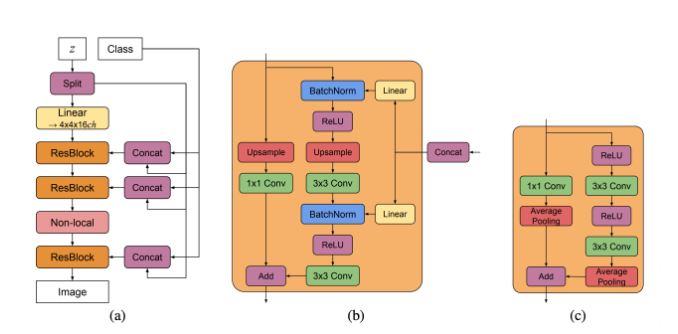
*BigGAN Architecture Components, taken from Figure 15 in [Large Scale GAN Training for High Fidelity Natural Image Synthesis](https://arxiv.org/abs/1809.11096) (Brock et al. 2019). (a) A typical architectural layout for BigGAN’s generator. See Appendix B for details. (b) A Residual Block (ResBlock up) in BigGAN’s generator. (c) A Residual Block (ResBlock down) in BigGAN’s discriminator.*

## The Truncation Trick and Orthogonal Regularization

You should already be familiar with the truncation trick, which truncates the range of values of random noise $z$. Truncation to values close to 0 increases fidelity but decreases variety. Truncation to values further from 0 does the opposite.

Truncation results in a different distribution of $z$ values from the one seen in training, which can cause saturation artifacts. The authors address this by making $G$ well-defined, or *smooth*, on the full distribution of $z$ values.

To do this, they employ orthogonal regularization, first introduced in [Neural Photo Editing with Introspective Adversarial Networks](https://arxiv.org/abs/1609.07093) (Brock et al. 2017). The authors modify this regularization technique for BigGAN and formulate it as

\begin{align*}
  R_\beta(W) = \beta\big|\big|W^\top W \odot (\pmb{1} - I)\big|\big|^2_F,
\end{align*}
where $\pmb{1}$ denotes a matrix of 1's. This regularization term removes the diagonal terms from the regularization and aims to minimize the pairwise cosine similarity between filters without constraining their norm.

> 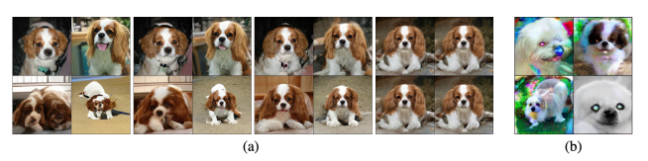
*Generated images with different truncation thresholds, taken from Figure 2 in [Large Scale GAN Training for High Fidelity Natural Image Synthesis](https://arxiv.org/abs/1809.11096) (Brock et al. 2019). (a) The effects of increasing truncation. From left to right, the threshold is set to 2, 1, 0.5, 0.04. (b) Saturation artifacts from applying truncation to a poorly conditioned model.*

Below is the implementation for orthogonal regularization. You can refer to the StyleGAN notebook for the truncation trick code.

In [ ]:
# Some setup
import torch
import torch.nn as nn
import torch.nn.functional as F

def orthogonal_regularization(weight):
    '''
    Function for computing the orthogonal regularization term for a given weight matrix.
    '''
    weight = weight.flatten(1)
    return torch.norm(
        torch.dot(weight, weight) * (torch.ones_like(weight) - torch.eye(weight.shape[0]))
    )

## BigGAN Parts

Before jumping into the full implementation, let's first take a look at some submodules that will be important in our BigGAN implementation later.

### Class-conditional Batch Normalization

Recall that batch norm aims to normalize activation statistics to a standard gaussian distribution (via an exponential moving average of minibatch mean and variances) but also applies trainable parameters, $\gamma$ and $\beta$, to invert this operation if the model sees fit:

\begin{align*}
    y &= \dfrac{x - \hat{\mu}}{\hat{\sigma} + \epsilon} * \gamma + \beta.
\end{align*}

BigGAN injects class-conditional information by parameterizing $\gamma$ and $\beta$ as linear transformations of the class embedding, $c$. Recall that BigGAN also concatenates $c$ with $z$ skip connections (denoted $[c, z]$), so

\begin{align*}
    \gamma &:= W_\gamma^\top[c, z] \\
    \beta &:= W_\beta^\top[c, z]
\end{align*}

The idea is actually very similar to the adaptive instance normalization (AdaIN) module that you implemented in the StyleGAN notebook, so we've copied that code in comments below for reference.

In [ ]:
class ClassConditionalBatchNorm2d(nn.Module):
    '''
    ClassConditionalBatchNorm2d Class
    Values:
    in_channels: the dimension of the class embedding (c) + noise vector (z), a scalar
    out_channels: the dimension of the activation tensor to be normalized, a scalar
    '''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.class_scale_transform = nn.utils.spectral_norm(nn.Linear(in_channels, out_channels, bias=False))
        self.class_shift_transform = nn.utils.spectral_norm(nn.Linear(in_channels, out_channels, bias=False))

    def forward(self, x, y):
        normalized_image = self.bn(x)
        class_scale = (1 + self.class_scale_transform(y))[:, :, None, None]
        class_shift = self.class_shift_transform(y)[:, :, None, None]
        transformed_image = class_scale * normalized_image + class_shift
        return transformed_image

# class AdaIN(nn.Module):
#     '''
#     AdaIN Class, extends/subclass of nn.Module
#     Values:
#       channels: the number of channels the image has, a scalar
#       w_dim: the dimension of the intermediate tensor, w, a scalar 
#     '''

#     def __init__(self, channels, w_dim):
#         super().__init__()
#         self.instance_norm = nn.InstanceNorm2d(channels)
#         self.style_scale_transform = nn.Linear(w_dim, channels)
#         self.style_shift_transform = nn.Linear(w_dim, channels)

#     def forward(self, image, w):
#         normalized_image = self.instance_norm(image)
#         style_scale = self.style_scale_transform(w)[:, :, None, None]
#         style_shift = self.style_shift_transform(w)[:, :, None, None]
#         transformed_image = style_scale * normalized_image + style_shift
#         return transformed_image


### Self-Attention Block

As you may already know, self-attention has been a successful technique in helping models learn arbitrary, long-term dependencies. [Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318) (Zhang et al. 2018) first introduced the self-attention mechanism into the GAN architecture. BigGAN augments its residual blocks with these attention blocks.

**A Quick Primer on Self-Attention**

Self-attention is just **scaled dot product attention**. Given a sequence $S$ (with images, $S$ is just the image flattened across its height and width), the model learns mappings to query ($Q$), key ($K$), and value ($V$) matrices:

\begin{align*}
    Q &:= W_q^\top S \\
    K &:= W_k^\top S \\
    V &:= W_v^\top S
\end{align*}

where $W_q$, $W_k$, and $W_v$ are learned parameters. The subsequent self-attention mechanism is then computed as

\begin{align*}
    \text{Attention}(Q, K, V) = \text{softmax}\left(\dfrac{QK^\top}{\sqrt{d_k}}\right)V
\end{align*}

where $d_k$ is the dimensionality of the $Q, K$ matrices (SA-GAN and BigGAN both omit this term). Intuitively, you can think of the *query* matrix as containing the representations of each position with respect to itself and the *key* matrix as containing the representations of each position with respect to the others. How important two positions are to each other is measured by dot product as $QK^\top$, hence **dot product attention**. A softmax is applied to convert these relative importances to a probability distribution over all positions.


Intuitively, the *value* matrix provides the importance weighting of the attention at each position, hence **scaled dot product attention**. Relevant positions should be assigned larger weight and irrelevant ones should be assigned smaller weight.

Don't worry if you don't understand this right away - it's a tough concept! For extra reading, you should check out [Attention Is All You Need](https://arxiv.org/abs/1706.03762) (Vaswani et al. 2017), which is the paper that first introduces this technique, and [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/), which breaks down and explains the self-attention mechanism clearly.

In [ ]:
class AttentionBlock(nn.Module):
    '''
    AttentionBlock Class
    Values:
    channels: number of channels in input
    '''
    def __init__(self, channels):
        super().__init__()

        self.channels = channels

        self.theta = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.phi = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.g = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 2, kernel_size=1, padding=0, bias=False))
        self.o = nn.utils.spectral_norm(nn.Conv2d(channels // 2, channels, kernel_size=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        spatial_size = x.shape[2] * x.shape[3]

        # Apply convolutions to get query (theta), key (phi), and value (g) transforms
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        # Reshape spatial size for self-attention
        theta = theta.view(-1, self.channels // 8, spatial_size)
        phi = phi.view(-1, self.channels // 8, spatial_size // 4)
        g = g.view(-1, self.channels // 2, spatial_size // 4)

        # Compute dot product attention with query (theta) and key (phi) matrices
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), dim=-1)

        # Compute scaled dot product attention with value (g) and attention (beta) matrices
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        # Apply gain and residual
        return self.gamma * o + x

## BigGAN Generator

Before implementing the generator in full, you first need to implement the generator residual block.

### Generator Residual Block

As with many state-of-the-art computer vision models, BigGAN employs skip connections in the form of residual blocks to map random noise to a fake image. You can think of BigGAN residual blocks as having 3 steps. Given input $x$ and class embedding $y$:
 1. $h :=$ `bn-relu-upsample-conv`$(x, y)$
 2. $h :=$ `bn-relu-conv`$(h, y)$
 3. $x :=$ `upsample-conv`$(x)$,

after which you can apply a residual connection and return $h + x$.

In [ ]:
class GResidualBlock(nn.Module):
    '''
    GResidualBlock Class
    Values:
    c_dim: the dimension of conditional vector [c, z], a scalar
    in_channels: the number of channels in the input, a scalar
    out_channels: the number of channels in the output, a scalar
    '''

    def __init__(self, c_dim, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.bn1 = ClassConditionalBatchNorm2d(c_dim, in_channels)
        self.bn2 = ClassConditionalBatchNorm2d(c_dim, out_channels)

        self.activation = nn.ReLU()
        self.upsample_fn = nn.Upsample(scale_factor=2)     # upsample occurs in every gblock

        self.mixin = (in_channels != out_channels)
        if self.mixin:
            self.conv_mixin = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

    def forward(self, x, y):
        # h := upsample(x, y)
        h = self.bn1(x, y)
        h = self.activation(h)
        h = self.upsample_fn(h)
        h = self.conv1(h)

        # h := conv(h, y)
        h = self.bn2(h, y)
        h = self.activation(h)
        h = self.conv2(h)

        # x := upsample(x)
        x = self.upsample_fn(x)
        if self.mixin:
            x = self.conv_mixin(x)

        return h + x

You can now implement the BigGAN generator in full!! Below is an implementation of the base model (at 128x128 resolution) from the paper.

> This implementation uses `nn.ModuleList` for convenience. If you're not familiar with this, you can think of it as simply a Pythonic list that registers your modules with the Pytorch backend. For more information, see the [torch.nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) documentation.

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of random noise sampled, a scalar
    shared_dim: the dimension of shared class embeddings, a scalar
    base_channels: the number of base channels, a scalar
    bottom_width: the height/width of image before it gets upsampled, a scalar
    n_classes: the number of image classes, a scalar
    '''
 
    def __init__(self, base_channels=96, bottom_width=4, z_dim=120, shared_dim=128, n_classes=1000):
        super().__init__()
 
        n_chunks = 6    # 5 (generator blocks) + 1 (generator input)
        self.z_chunk_size = z_dim // n_chunks
        self.z_dim = z_dim
        self.shared_dim = shared_dim
        self.bottom_width = bottom_width
 
        # No spectral normalization on embeddings, which authors observe to cripple the generator
        self.shared_emb = nn.Embedding(n_classes, shared_dim)
 
        self.proj_z = nn.Linear(self.z_chunk_size, 16 * base_channels * bottom_width ** 2)
 
        # Can't use one big nn.Sequential since we are adding class+noise at each block
        self.g_blocks = nn.ModuleList([
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 16 * base_channels, 16 * base_channels),
                AttentionBlock(16 * base_channels),
            ]),
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 16 * base_channels, 8 * base_channels),
                AttentionBlock(8 * base_channels),
            ]),
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 8 * base_channels, 4 * base_channels),
                AttentionBlock(4 * base_channels),
            ]),
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 4 * base_channels, 2 * base_channels),
                AttentionBlock(2 * base_channels),
            ]),
            nn.ModuleList([
                GResidualBlock(shared_dim + self.z_chunk_size, 2 * base_channels, base_channels),
                AttentionBlock(base_channels),
            ]),
        ])
        self.proj_o = nn.Sequential(
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(base_channels, 3, kernel_size=1, padding=0)),
            nn.Tanh(),
        )
 
    def forward(self, z, y):
        '''
        z: random noise with size self.z_dim
        y: class embeddings with size self.shared_dim
            = NOTE =
            y should be class embeddings from self.shared_emb, not the raw class labels
        '''
        # Chunk z and concatenate to shared class embeddings
        zs = torch.split(z, self.z_chunk_size, dim=1)
        z = zs[0]
        ys = [torch.cat([y, z], dim=1) for z in zs[1:]]
 
        # Project noise and reshape to feed through generator blocks
        h = self.proj_z(z)
        h = h.view(h.size(0), -1, self.bottom_width, self.bottom_width)
 
        # Feed through generator blocks
        for idx, g_block in enumerate(self.g_blocks):
            h = g_block[0](h, ys[idx])
            h = g_block[1](h)
 
        # Project to 3 RGB channels with tanh to map values to [-1, 1]
        h = self.proj_o(h)
 
        return h

## BigGAN Discriminator

Before implementing the discriminator in full, you need to implement a discriminator residual block, which is simpler than the generator's. Note that the last residual block does not apply downsampling.
 1. $h :=$ `relu-conv-relu-downsample`$(x)$
 2. $x :=$ `conv-downsample`$(x)$

In the official BigGAN implementation, the architecture is slightly different for the first discriminator residual block, since it handles the raw image as input:
 1. $h :=$ `conv-relu-downsample`$(x)$
 2. $x :=$ `downsample-conv`$(x)$

After these two steps, you can return the residual connection $h + x$. You might notice that there is no class information in these residual blocks. As you'll see later in the code, the authors inject class-conditional information after the final hidden layer (and before the output layer) via channel-wise dot product.

In [ ]:
class DResidualBlock(nn.Module):
    '''
    DResidualBlock Class
    Values:
    in_channels: the number of channels in the input, a scalar
    out_channels: the number of channels in the output, a scalar
    downsample: whether to apply downsampling
    use_preactivation: whether to apply an activation function before the first convolution
    '''

    def __init__(self, in_channels, out_channels, downsample=True, use_preactivation=False):
        super().__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        self.activation = nn.ReLU()
        self.use_preactivation = use_preactivation  # apply preactivation in all except first dblock

        self.downsample = downsample    # downsample occurs in all except last dblock
        if downsample:
            self.downsample_fn = nn.AvgPool2d(2)
        self.mixin = (in_channels != out_channels) or downsample
        if self.mixin:
            self.conv_mixin = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0))

    def _residual(self, x):
        if self.use_preactivation:
            if self.mixin:
                x = self.conv_mixin(x)
            if self.downsample:
                x = self.downsample_fn(x)
        else:
            if self.downsample:
                x = self.downsample_fn(x)
            if self.mixin:
                x = self.conv_mixin(x)
        return x

    def forward(self, x):
        # Apply preactivation if applicable
        if self.use_preactivation:
            h = F.relu(x)
        else:
            h = x

        h = self.conv1(h)
        h = self.activation(h)
        if self.downsample:
            h = self.downsample_fn(h)

        return h + self._residual(x)

Now implement the BigGAN discriminator in full!!

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    base_channels: the number of base channels, a scalar
    n_classes: the number of image classes, a scalar
    '''

    def __init__(self, base_channels=96, n_classes=1000):
        super().__init__()

        # For adding class-conditional evidence
        self.shared_emb = nn.utils.spectral_norm(nn.Embedding(n_classes, 16 * base_channels))

        self.d_blocks = nn.Sequential(
            DResidualBlock(3, base_channels, downsample=True, use_preactivation=False),
            AttentionBlock(base_channels),

            DResidualBlock(base_channels, 2 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(2 * base_channels),

            DResidualBlock(2 * base_channels, 4 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(4 * base_channels),

            DResidualBlock(4 * base_channels, 8 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(8 * base_channels),

            DResidualBlock(8 * base_channels, 16 * base_channels, downsample=True, use_preactivation=True),
            AttentionBlock(16 * base_channels),

            DResidualBlock(16 * base_channels, 16 * base_channels, downsample=False, use_preactivation=True),
            AttentionBlock(16 * base_channels),

            nn.ReLU(inplace=True),
        )
        self.proj_o = nn.utils.spectral_norm(nn.Linear(16 * base_channels, 1))

    def forward(self, x, y=None):
        h = self.d_blocks(x)
        h = torch.sum(h, dim=[2, 3])

        # Class-unconditional output
        uncond_out = self.proj_o(h)
        if y is None:
            return uncond_out

        # Class-conditional output
        cond_out = torch.sum(self.shared_emb(y) * h, dim=1, keepdim=True)
        return uncond_out + cond_out

## Setting Up BigGAN Training

Now you're are ready to set up BigGAN for training! Unfortunately, this notebook will not provide actual training code due to the size of BigGAN.

In [ ]:
device = 'cpu'

# Initialize models
base_channels = 96
z_dim = 120
n_classes = 5   # 5 classes is used instead of the original 1000, for efficiency
shared_dim = 128
generator = Generator(base_channels=base_channels, bottom_width=4, z_dim=z_dim, shared_dim=shared_dim, n_classes=n_classes).to(device)
discriminator = Discriminator(base_channels=base_channels, n_classes=n_classes).to(device)

# Initialize weights orthogonally
for module in generator.modules():
    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
        nn.init.orthogonal_(module.weight)
for module in discriminator.modules():
    if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
        nn.init.orthogonal_(module.weight)

# Initialize optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.999), eps=1e-6)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.0, 0.999), eps=1e-6)

Here is a sample forward pass:

In [ ]:
batch_size = n_classes

z = torch.randn(batch_size, z_dim, device=device)                 # Generate random noise (z)
y = torch.arange(start=0, end=n_classes, device=device).long()    # Generate a batch of labels (y), one for each class
y_emb = generator.shared_emb(y)                                   # Retrieve class embeddings (y_emb) from generator

x_gen = generator(z, y_emb)                                       # Generate fake images from z and y_emb
score = discriminator(x_gen, y)                                   # Generate classification for fake images

## BigGAN-deep

Initially, the authors of the BigGAN paper didn't find much help in increasing the depth of the network. But they experimented further (research is always improving!) and added a few notes about an additional architecture, called BigGAN-deep. This modification of BigGAN is 4x deeper, sports a modified residual block architecture, and concatenates the entire $z$ vector to $c$ (as opposed to separate chunks at different resolutions).

Typically on a difficult and complex task that you're unlikely to overfit, you expect better performance when a model has more parameters, because it has more room to learn. Surprisingly, BigGAN-deep has fewer parameters than its BigGAN counterpart. Architectural optimizations such as using depthwise separable convolutions and truncating/concatenating channels in skip connections (as opposed to using pointwise convolutions) decrease parameters without trading expressivity.

For more details on the BigGAN-deep architecture, see Appendix B of the paper.

And as for the implementation of the BigGAN-deep variant, well, that's left as an exercise for the reader. You're a smart cookie, you'll figure it out! Just keep in mind that with great power comes great responsibility ;)